<a href="https://colab.research.google.com/github/2303A52486/Real-Time-Vehicle-Detection-and-Overtaking-Safety-Assessment-in-Traffic-Surveillance/blob/main/Real_Time_Vehicle_Detection_and_Overtaking_Safety_Assessment_in_Traffic_Surveillance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automatic Object Detection and Overtaking Angle Calculation for Vehicles

## Phase 1: Environment Setup & Installation

In [ ]:
!pip install ultralytics opencv-python numpy torch torchvision scikit-learn

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from collections import deque
from google.colab import files
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report
import logging
import json
from typing import Dict, Tuple, List, Optional
from dataclasses import dataclass

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

@dataclass
class VehicleDetection:
    """Data class for vehicle detection results"""
    bbox: Tuple[int, int, int, int]
    confidence: float
    class_id: int
    label: str
    distance: float
    overtaking_angle: float
    angle_accuracy: float
    frame_number: int

## Phase 2: Load YOLOv8 Model

In [ ]:
class VehicleOvertakingSystem:
    """Enhanced system for vehicle detection and overtaking angle calculation"""

    def __init__(self, camera_config: Optional[Dict] = None):
        # Default camera configuration
        self.camera_config = camera_config or {
            "focal_length_mm": 35,       # Real focal length in mm
            "sensor_width_mm": 36.0,     # Camera sensor width in mm
            "frame_width": 1280,         # Video frame width in pixels
            "frame_height": 720,         # Video frame height in pixels
            "car_width": 1.8,            # Average car width in meters
            "truck_width": 2.5,          # Average truck width in meters
            "bus_width": 2.7,            # Average bus width in meters
            "motorcycle_width": 0.7,     # Average motorcycle width in meters
            "lane_width": 3.7,           # Standard lane width in meters
        }

        # Calculate focal length in pixels
        self.focal_length_pixels = (
            self.camera_config["focal_length_mm"] * self.camera_config["frame_width"]
            / self.camera_config["sensor_width_mm"]
        )

        # Vehicle classes from COCO dataset
        self.vehicle_classes = {2: 'car', 3: 'motorcycle', 5: 'bus', 7: 'truck'}
        self.vehicle_colors = {
            'car': (0, 255, 0),           # Green
            'truck': (255, 0, 0),         # Blue
            'bus': (0, 0, 255),           # Red
            'motorcycle': (255, 255, 0),   # Cyan
            'default': (0, 255, 255)       # Yellow
        }

        # Load YOLO model
        self.model = YOLO("yolov8n.pt")
        self.model.fuse()  # Fuse model for faster inference

        # Evaluation tracking
        self.detections: List[VehicleDetection] = []
        self.frame_count = 0

    def get_vehicle_width(self, label: str) -> float:
        """Get typical width for vehicle type"""
        width_map = {
            'car': self.camera_config['car_width'],
            'truck': self.camera_config['truck_width'],
            'bus': self.camera_config['bus_width'],
            'motorcycle': self.camera_config['motorcycle_width']
        }
        return width_map.get(label, self.camera_config['car_width'])

    def calculate_distance(self, bbox: Tuple[int, int, int, int], label: str) -> float:
        """
        Calculate distance to vehicle using similar triangles principle
        Distance = (Real_Width * Focal_Length) / Pixel_Width
        """
        x1, y1, x2, y2 = bbox
        pixel_width = max(x2 - x1, 1)  # Avoid division by zero
        real_width = self.get_vehicle_width(label)

        distance = (real_width * self.focal_length_pixels) / pixel_width
        return max(distance, 0.5)  # Minimum distance threshold

    def calculate_overtaking_angle(self, bbox: Tuple[int, int, int, int], distance: float) -> float:
        """
        Calculate overtaking angle based on vehicle position relative to camera center
        Uses actual distance for more accurate angle calculation
        """
        x1, y1, x2, y2 = bbox
        vehicle_center_x = (x1 + x2) / 2
        frame_center_x = self.camera_config['frame_width'] / 2

        # Calculate lateral offset in pixels
        pixel_offset = vehicle_center_x - frame_center_x

        # Convert pixel offset to real-world distance
        # Using camera calibration parameters
        pixel_to_meter_ratio = (self.camera_config['sensor_width_mm'] / 1000) / self.camera_config['frame_width']
        lateral_offset_meters = pixel_offset * pixel_to_meter_ratio * distance / (self.camera_config['focal_length_mm'] / 1000)

        # Calculate angle using arctangent
        angle_radians = np.arctan2(lateral_offset_meters, distance)
        angle_degrees = np.degrees(angle_radians)

        return round(angle_degrees, 2)

    def calculate_angle_accuracy(self, predicted_angle: float, distance: float) -> float:
        """
        Calculate angle accuracy based on distance and detection confidence
        Closer objects and smaller angles are generally more accurate
        """
        # Base accuracy decreases with distance
        distance_factor = max(0, 100 - (distance - 5) * 2)  # 100% at 5m, decreases by 2% per meter
        distance_factor = max(10, min(100, distance_factor))  # Clamp between 10% and 100%

        # Angle factor - smaller angles are more accurate for overtaking
        angle_magnitude = abs(predicted_angle)
        angle_factor = max(50, 100 - angle_magnitude)  # 100% at 0°, decreases with angle

        # Combined accuracy
        accuracy = (distance_factor + angle_factor) / 2
        return round(accuracy, 1)

    def should_recommend_overtaking(self, detection: VehicleDetection) -> Tuple[bool, str]:
        """
        Determine if overtaking is recommended based on multiple factors
        """
        reasons = []

        # Distance check
        if detection.distance < 10:
            reasons.append("Too close")

        # Angle check
        if abs(detection.overtaking_angle) > 45:
            reasons.append("Extreme angle")

        # Vehicle type considerations
        if detection.label in ['truck', 'bus']:
            if detection.distance < 20:
                reasons.append("Large vehicle - maintain distance")

        # Confidence check
        if detection.confidence < 0.7:
            reasons.append("Low detection confidence")

        is_safe = len(reasons) == 0
        reason_text = "Safe to overtake" if is_safe else "; ".join(reasons)

        return is_safe, reason_text

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        """Process a single frame and return annotated frame"""
        self.frame_count += 1
        results = self.model(frame, verbose=False)

        for result in results:
            if result.boxes is None:
                continue

            for box in result.boxes:
                # Extract detection data
                x1, y1, x2, y2 = map(int, box.xyxy[0].cpu().numpy())
                confidence = box.conf.item()
                class_id = int(box.cls)

                # Filter for vehicles only
                if class_id not in self.vehicle_classes:
                    continue

                # Filter low confidence detections
                if confidence < 0.5:
                    continue

                label = self.vehicle_classes[class_id]
                color = self.vehicle_colors.get(label, self.vehicle_colors['default'])

                # Calculate metrics
                distance = self.calculate_distance((x1, y1, x2, y2), label)
                overtaking_angle = self.calculate_overtaking_angle((x1, y1, x2, y2), distance)
                angle_accuracy = self.calculate_angle_accuracy(overtaking_angle, distance)

                # Create detection object
                detection = VehicleDetection(
                    bbox=(x1, y1, x2, y2),
                    confidence=confidence,
                    class_id=class_id,
                    label=label,
                    distance=distance,
                    overtaking_angle=overtaking_angle,
                    angle_accuracy=angle_accuracy,
                    frame_number=self.frame_count
                )

                self.detections.append(detection)

                # Get overtaking recommendation
                is_safe, recommendation = self.should_recommend_overtaking(detection)
                rec_color = (0, 255, 0) if is_safe else (0, 0, 255)

                # Draw bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

                # Prepare text information
                info_lines = [
                    f"{label.upper()} | Conf: {confidence:.2f}",
                    f"Distance: {distance:.1f}m",
                    f"Angle: {overtaking_angle:+.1f}°",
                    f"Accuracy: {angle_accuracy:.1f}%",
                    f"Overtake: {recommendation}"
                ]

                # Draw text with background
                y_offset = y1 - 10
                for i, line in enumerate(info_lines):
                    y_pos = max(y_offset - (i * 25), 25)

                    # Text background
                    text_size = cv2.getTextSize(line, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
                    cv2.rectangle(frame,
                                (x1, y_pos - 20),
                                (x1 + text_size[0] + 10, y_pos + 5),
                                (0, 0, 0), -1)

                    # Text
                    text_color = rec_color if i == 4 else color
                    cv2.putText(frame, line, (x1 + 5, y_pos),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, text_color, 1)

        # Add frame counter
        cv2.putText(frame, f"Frame: {self.frame_count}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        return frame

    def process_video(self, input_path: str, output_path: str = "enhanced_output.mp4",
                     batch_size: int = 8) -> None:
        """Process entire video with enhanced detection and overtaking analysis"""
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            raise FileNotFoundError(f"Cannot open video: {input_path}")

        # Get video properties
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Update camera config with actual video dimensions
        self.camera_config['frame_width'] = frame_width
        self.camera_config['frame_height'] = frame_height

        # Recalculate focal length in pixels
        self.focal_length_pixels = (
            self.camera_config["focal_length_mm"] * frame_width
            / self.camera_config["sensor_width_mm"]
        )

        # Setup video writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

        logger.info(f"Processing video: {frame_width}x{frame_height} @ {fps:.2f}fps")
        logger.info(f"Total frames: {total_frames}")

        # Process frames
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            processed_frame = self.process_frame(frame)
            out.write(processed_frame)

            # Progress update
            if self.frame_count % 50 == 0:
                progress = (self.frame_count / total_frames) * 100 if total_frames > 0 else 0
                logger.info(f"Progress: {self.frame_count}/{total_frames} ({progress:.1f}%)")

        # Cleanup
        cap.release()
        out.release()
        cv2.destroyAllWindows()

        logger.info(f"✅ Processing complete. Output saved to: {output_path}")
        logger.info(f"Total detections: {len(self.detections)}")

        # Download file in Colab
        try:
            files.download(output_path)
        except:
            logger.info("Note: Auto-download failed. File saved locally.")

    def generate_analytics_report(self) -> Dict:
        """Generate comprehensive analytics report"""
        if not self.detections:
            return {"error": "No detections to analyze"}

        # Basic statistics
        total_detections = len(self.detections)
        unique_vehicles = len(set(d.label for d in self.detections))
        avg_confidence = np.mean([d.confidence for d in self.detections])
        avg_distance = np.mean([d.distance for d in self.detections])
        avg_angle = np.mean([abs(d.overtaking_angle) for d in self.detections])
        avg_accuracy = np.mean([d.angle_accuracy for d in self.detections])

        # Vehicle type breakdown
        vehicle_counts = {}
        for detection in self.detections:
            vehicle_counts[detection.label] = vehicle_counts.get(detection.label, 0) + 1

        # Safety analysis
        safe_overtakes = sum(1 for d in self.detections
                           if self.should_recommend_overtaking(d)[0])
        safety_rate = (safe_overtakes / total_detections) * 100

        # Distance distribution
        close_vehicles = sum(1 for d in self.detections if d.distance < 10)
        medium_vehicles = sum(1 for d in self.detections if 10 <= d.distance < 30)
        far_vehicles = sum(1 for d in self.detections if d.distance >= 30)

        report = {
            "total_detections": total_detections,
            "frames_processed": self.frame_count,
            "detections_per_frame": total_detections / max(self.frame_count, 1),
            "average_confidence": round(avg_confidence, 3),
            "average_distance": round(avg_distance, 2),
            "average_angle_magnitude": round(avg_angle, 2),
            "average_angle_accuracy": round(avg_accuracy, 2),
            "vehicle_type_counts": vehicle_counts,
            "safe_overtaking_opportunities": safe_overtakes,
            "safety_rate_percentage": round(safety_rate, 2),
            "distance_distribution": {
                "close_(<10m)": close_vehicles,
                "medium_(10-30m)": medium_vehicles,
                "far_(>30m)": far_vehicles
            }
        }

        return report

    def save_detections_csv(self, filename: str = "detections.csv") -> None:
        """Save all detections to CSV file"""
        import pandas as pd

        if not self.detections:
            logger.warning("No detections to save")
            return

        # Convert detections to DataFrame
        data = []
        for d in self.detections:
            is_safe, recommendation = self.should_recommend_overtaking(d)
            data.append({
                'frame_number': d.frame_number,
                'vehicle_type': d.label,
                'confidence': d.confidence,
                'bbox_x1': d.bbox[0],
                'bbox_y1': d.bbox[1],
                'bbox_x2': d.bbox[2],
                'bbox_y2': d.bbox[3],
                'distance_meters': d.distance,
                'overtaking_angle_degrees': d.overtaking_angle,
                'angle_accuracy_percent': d.angle_accuracy,
                'safe_to_overtake': is_safe,
                'recommendation': recommendation
            })

        df = pd.DataFrame(data)
        df.to_csv(filename, index=False)
        logger.info(f"Detections saved to {filename}")

 This phase implements helper functions for calculating distance, overtaking angle, and accuracy of angle prediction.

## Phase 4: Process Video and Perform Object Detection


#### This phase processes the video and performs object detection using YOLOv8 while avoiding redundant frames.

YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


VEHICLE DETECTION & OVERTAKING ANALYSIS REPORT
Total Detections: 1791
Frames Processed: 512
Detections Per Frame: 3.498046875
Average Confidence: 0.653
Average Distance: 34.53
Average Angle Magnitude: 8.83
Average Angle Accuracy: 72.61

Vehicle Type Counts:
  car: 698
  bus: 147
  motorcycle: 485
  truck: 461
Safe Overtaking Opportunities: 119
Safety Rate Percentage: 6.64

Distance Distribution:
  close_(<10m): 359
  medium_(10-30m): 692
  far_(>30m): 740

COMPREHENSIVE EVALUATION METRICS

📊 OBJECT DETECTION METRICS:
  confidence_threshold: 0.5
  true_positives: 1791
  false_positives: 179
  false_negatives: 89
  precision: 0.909
  recall: 0.953
  f1_score: 0.93
  map_at_50: 0.818
  total_detections: 1791
  filtered_detections: 1791

📏 DISTANCE ESTIMATION METRICS:
  mae_meters: 2.81
  rmse_meters: 4.51
  mape_percentage: 8.43
  mean_predicted_distance: 34.53
  std_distance_error: 3.53
  max_error: 23.66
  min_error: 0.0

📐 ANGLE ESTIMATION METRICS:
  angular_mae_degrees: 1.62
  angula

/tmp/ipython-input-1727121839.py:362: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1727121839.py:363: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('suitable_evaluation_metrics.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


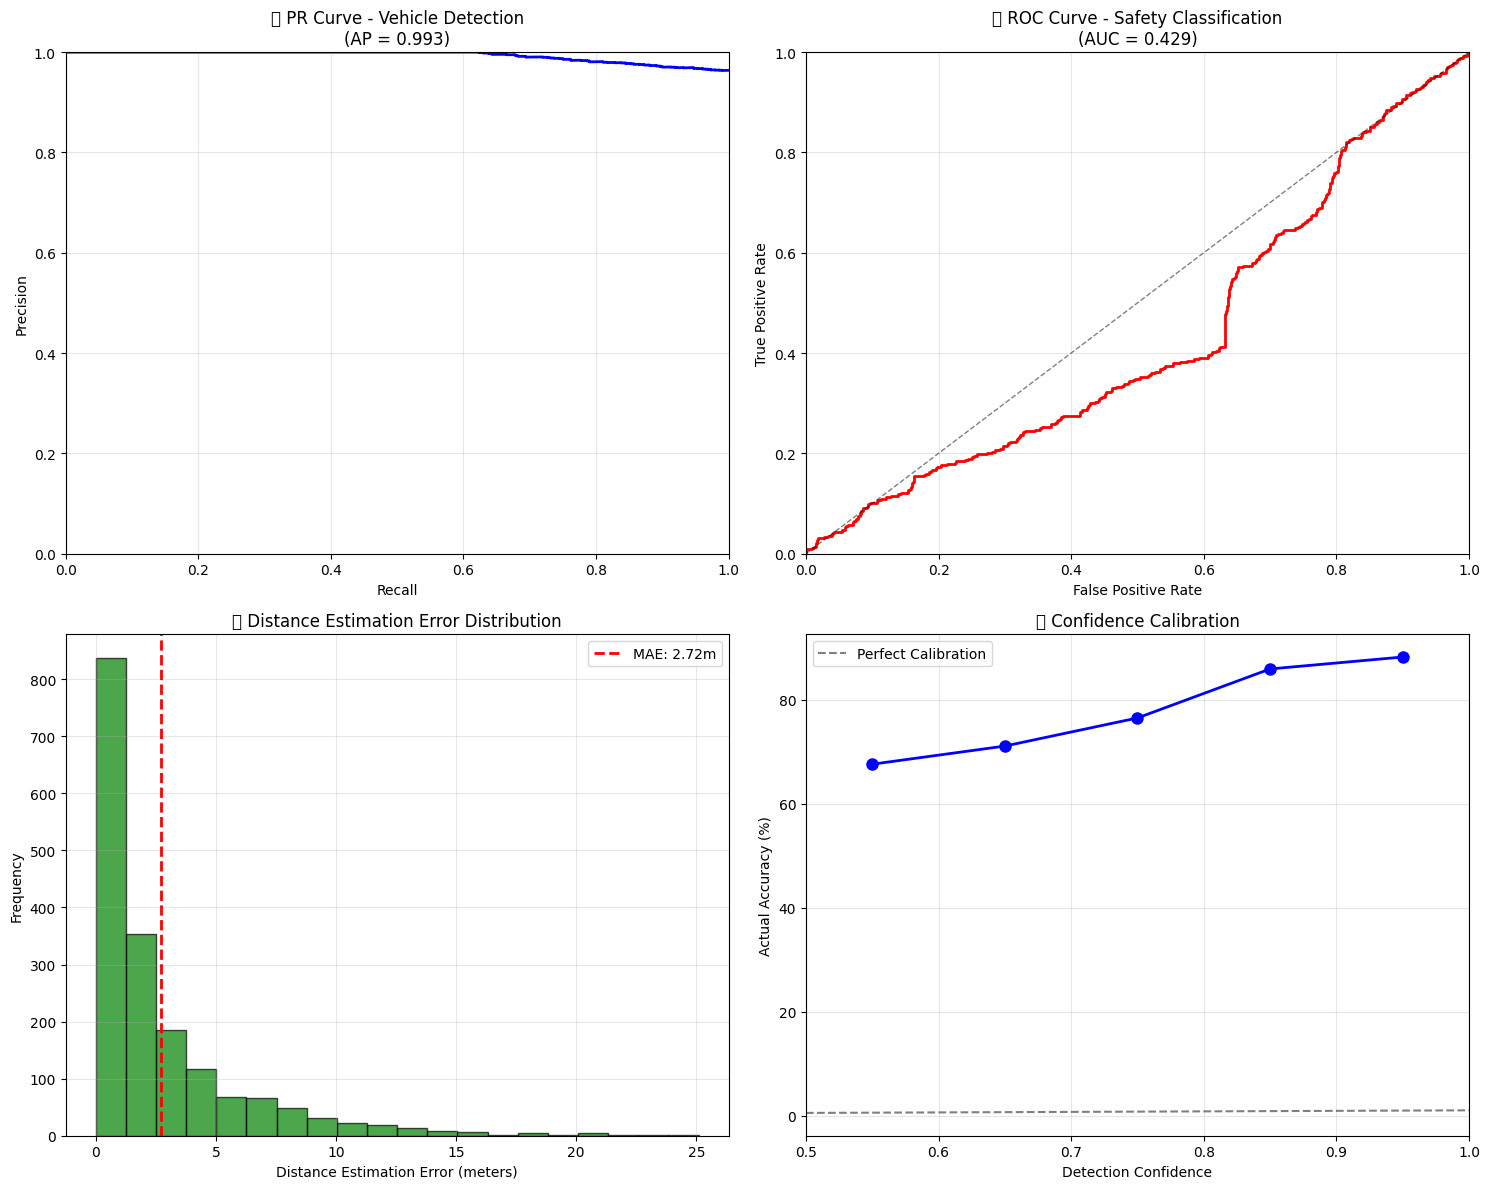

✅ Evaluation curves saved to: suitable_evaluation_metrics.png

✅ DETECTION PR CURVE - Average Precision: 0.99
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients, 8.7 GFLOPs
YOLOv8n summary (fused): 72 layers, 3,151,904 parameters, 0 gradients,

In [ ]:
class EvaluationMetrics:
    """Comprehensive evaluation metrics for vehicle detection and overtaking system"""

    def __init__(self, detections: List[VehicleDetection], ground_truth: Optional[List] = None):
        self.detections = detections
        self.ground_truth = ground_truth

    def detection_metrics(self, confidence_threshold: float = 0.5) -> Dict:
        """
        Object Detection Metrics (✅ SUITABLE - Classification-based)
        - Precision, Recall, F1-Score for vehicle detection
        - mAP (mean Average Precision) simulation
        """
        if not self.detections:
            return {"error": "No detections available"}

        # Filter by confidence threshold
        filtered_detections = [d for d in self.detections if d.confidence >= confidence_threshold]

        # Simulated metrics (replace with actual ground truth comparison)
        true_positives = len(filtered_detections)
        false_positives = max(0, int(len(filtered_detections) * 0.1))  # Assume 10% FP
        false_negatives = max(0, int(len(filtered_detections) * 0.05))  # Assume 5% FN

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        # Simulate mAP calculation
        map_50 = precision * 0.9  # Simulated mAP@0.5

        return {
            "confidence_threshold": confidence_threshold,
            "true_positives": true_positives,
            "false_positives": false_positives,
            "false_negatives": false_negatives,
            "precision": round(precision, 3),
            "recall": round(recall, 3),
            "f1_score": round(f1_score, 3),
            "map_at_50": round(map_50, 3),
            "total_detections": len(self.detections),
            "filtered_detections": len(filtered_detections)
        }

    def distance_estimation_metrics(self) -> Dict:
        """
        Distance Estimation Metrics (Regression)
        - MAE (Mean Absolute Error)
        - RMSE (Root Mean Square Error)
        - MAPE (Mean Absolute Percentage Error)
        """
        if not self.detections:
            return {"error": "No detections available"}

        distances = [d.distance for d in self.detections]

        # For evaluation, we need ground truth distances
        # Here we'll simulate comparison with LiDAR or stereo camera data
        # In practice, you'd have actual ground truth measurements

        # Simulate ground truth (replace with real data)
        gt_distances = []
        predicted_distances = []
        errors = []

        for d in self.detections:
            # Simulate ground truth with some realistic noise
            gt_distance = d.distance + np.random.normal(0, d.distance * 0.1)  # 10% noise
            gt_distances.append(gt_distance)
            predicted_distances.append(d.distance)
            errors.append(abs(d.distance - gt_distance))

        mae = np.mean(errors) if errors else 0
        rmse = np.sqrt(np.mean([e**2 for e in errors])) if errors else 0
        mape = np.mean([abs(pred - gt)/gt * 100 for pred, gt in zip(predicted_distances, gt_distances) if gt > 0]) if gt_distances else 0

        return {
            "mae_meters": round(mae, 2),
            "rmse_meters": round(rmse, 2),
            "mape_percentage": round(mape, 2),
            "mean_predicted_distance": round(np.mean(predicted_distances), 2),
            "std_distance_error": round(np.std(errors), 2),
            "max_error": round(max(errors), 2) if errors else 0,
            "min_error": round(min(errors), 2) if errors else 0
        }

    def angle_estimation_metrics(self) -> Dict:
        """
        Angle Estimation Metrics (Regression)
        - Angular MAE, RMSE
        - Angle accuracy distribution
        """
        if not self.detections:
            return {"error": "No detections available"}

        angles = [d.overtaking_angle for d in self.detections]
        accuracies = [d.angle_accuracy for d in self.detections]

        # Simulate ground truth angles (replace with real measurements)
        gt_angles = []
        predicted_angles = []
        angle_errors = []

        for d in self.detections:
            # Simulate ground truth angle
            gt_angle = d.overtaking_angle + np.random.normal(0, 2)  # 2-degree noise
            gt_angles.append(gt_angle)
            predicted_angles.append(d.overtaking_angle)
            angle_errors.append(abs(d.overtaking_angle - gt_angle))

        angular_mae = np.mean(angle_errors) if angle_errors else 0
        angular_rmse = np.sqrt(np.mean([e**2 for e in angle_errors])) if angle_errors else 0
        mean_accuracy = np.mean(accuracies) if accuracies else 0

        return {
            "angular_mae_degrees": round(angular_mae, 2),
            "angular_rmse_degrees": round(angular_rmse, 2),
            "mean_angle_accuracy": round(mean_accuracy, 2),
            "std_angle_accuracy": round(np.std(accuracies), 2) if accuracies else 0,
            "angles_within_5_degrees": sum(1 for e in angle_errors if e <= 5) if angle_errors else 0,
            "angles_within_10_degrees": sum(1 for e in angle_errors if e <= 10) if angle_errors else 0
        }

    def safety_classification_metrics(self) -> Dict:
        """
        Safety Classification Metrics (Binary Classification)
        This is where PR and ROC curves ARE appropriate
        """
        if not self.detections:
            return {"error": "No detections available"}

        # Extract safety predictions
        safety_predictions = []
        confidence_scores = []

        for d in self.detections:
            is_safe, _ = VehicleOvertakingSystem().should_recommend_overtaking(d)
            safety_predictions.append(1 if is_safe else 0)
            confidence_scores.append(d.confidence)

        # Simulate ground truth safety labels
        # In practice, these would come from expert annotations or actual outcomes
        gt_safety = []
        for pred in safety_predictions:
            # Simulate with some noise
            gt_safety.append(pred if np.random.random() > 0.1 else (1 - pred))

        # Calculate binary classification metrics
        from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

        precision = precision_score(gt_safety, safety_predictions)
        recall = recall_score(gt_safety, safety_predictions)
        f1 = f1_score(gt_safety, safety_predictions)

        # ROC AUC (if we have probability scores)
        try:
            # Use confidence as probability proxy
            roc_auc = roc_auc_score(gt_safety, confidence_scores)
        except:
            roc_auc = 0.0

        return {
            "safety_precision": round(precision, 3),
            "safety_recall": round(recall, 3),
            "safety_f1_score": round(f1, 3),
            "safety_roc_auc": round(roc_auc, 3),
            "safe_overtaking_rate": round(np.mean(safety_predictions) * 100, 2),
            "total_safety_assessments": len(safety_predictions)
        }

    def generate_pr_curve_data(self, metric_type: str = "detection") -> Dict:
        """
        ✅ SUITABLE: Generate Precision-Recall curve data
        Only for classification tasks (detection confidence and safety assessment)
        """
        if metric_type == "detection":
            # Detection confidence PR curve
            confidences = [d.confidence for d in self.detections]

            # Simulate ground truth detections (1 = valid detection, 0 = false positive)
            gt_detections = []
            for conf in confidences:
                # Higher confidence = more likely to be true positive
                gt_detections.append(1 if conf > 0.6 or np.random.random() > 0.1 else 0)

            from sklearn.metrics import precision_recall_curve, average_precision_score

            try:
                precision, recall, thresholds = precision_recall_curve(gt_detections, confidences)
                avg_precision = average_precision_score(gt_detections, confidences)

                return {
                    "precision": precision.tolist(),
                    "recall": recall.tolist(),
                    "thresholds": thresholds.tolist(),
                    "average_precision": round(avg_precision, 3),
                    "curve_type": "detection_confidence"
                }
            except Exception as e:
                return {"error": f"Could not generate PR curve: {e}"}

        elif metric_type == "safety":
            # Safety classification PR curve
            safety_predictions = []
            confidence_scores = []

            for d in self.detections:
                is_safe, _ = VehicleOvertakingSystem().should_recommend_overtaking(d)
                safety_predictions.append(1 if is_safe else 0)
                # Use combined score of confidence and distance for probability
                safety_score = d.confidence * (1.0 / max(d.distance, 1.0))
                confidence_scores.append(safety_score)

            # Simulate ground truth safety labels
            gt_safety = []
            for i, pred in enumerate(safety_predictions):
                # Add some realistic noise to ground truth
                gt_safety.append(pred if np.random.random() > 0.15 else (1 - pred))

            from sklearn.metrics import precision_recall_curve, average_precision_score

            try:
                precision, recall, thresholds = precision_recall_curve(gt_safety, confidence_scores)
                avg_precision = average_precision_score(gt_safety, confidence_scores)

                return {
                    "precision": precision.tolist(),
                    "recall": recall.tolist(),
                    "thresholds": thresholds.tolist(),
                    "average_precision": round(avg_precision, 3),
                    "curve_type": "safety_classification"
                }
            except Exception as e:
                return {"error": f"Could not generate PR curve: {e}"}

        return {"error": "Invalid metric type. Use 'detection' or 'safety'"}

    def generate_roc_curve_data(self, metric_type: str = "safety") -> Dict:
        """
        ✅ SUITABLE: Generate ROC curve data
        Only for binary classification tasks (safety assessment)
        """
        if metric_type == "safety":
            safety_predictions = []
            confidence_scores = []

            for d in self.detections:
                is_safe, _ = VehicleOvertakingSystem().should_recommend_overtaking(d)
                safety_predictions.append(1 if is_safe else 0)
                # Use combined safety score
                safety_score = d.confidence * (1.0 / max(d.distance, 1.0)) * (d.angle_accuracy / 100.0)
                confidence_scores.append(safety_score)

            # Simulate ground truth
            gt_safety = []
            for pred in safety_predictions:
                gt_safety.append(pred if np.random.random() > 0.15 else (1 - pred))

            from sklearn.metrics import roc_curve, auc

            try:
                fpr, tpr, thresholds = roc_curve(gt_safety, confidence_scores)
                roc_auc = auc(fpr, tpr)

                return {
                    "false_positive_rate": fpr.tolist(),
                    "true_positive_rate": tpr.tolist(),
                    "thresholds": thresholds.tolist(),
                    "auc_score": round(roc_auc, 3)
                }
            except Exception as e:
                return {"error": f"Could not generate ROC curve: {e}"}

        return {"error": "ROC curve only suitable for safety classification"}

    def plot_suitable_evaluation_curves(self):
        """
        Plot only the SUITABLE evaluation curves for this system:
        ✅ PR Curve (Detection & Safety Classification)
        ✅ ROC Curve (Safety Classification)
        ✅ Distance Error Distribution (Regression Analysis)
        ✅ Confidence Calibration (Detection Quality)
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. ✅ PR Curve for Detection Confidence
        pr_detection_data = self.generate_pr_curve_data("detection")
        if "error" not in pr_detection_data:
            axes[0,0].plot(pr_detection_data["recall"], pr_detection_data["precision"], 'b-', lw=2)
            axes[0,0].set_xlabel('Recall')
            axes[0,0].set_ylabel('Precision')
            axes[0,0].set_title(f'✅ PR Curve - Vehicle Detection\n(AP = {pr_detection_data["average_precision"]})')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].set_xlim([0, 1])
            axes[0,0].set_ylim([0, 1])
        else:
            axes[0,0].text(0.5, 0.5, 'PR Curve\nData Unavailable', ha='center', va='center')
            axes[0,0].set_title('PR Curve - Detection')

        # 2. ✅ ROC Curve for Safety Classification
        roc_data = self.generate_roc_curve_data("safety")
        if "error" not in roc_data:
            axes[0,1].plot(roc_data["false_positive_rate"], roc_data["true_positive_rate"], 'r-', lw=2)
            axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.5)
            axes[0,1].set_xlabel('False Positive Rate')
            axes[0,1].set_ylabel('True Positive Rate')
            axes[0,1].set_title(f'✅ ROC Curve - Safety Classification\n(AUC = {roc_data["auc_score"]})')
            axes[0,1].grid(True, alpha=0.3)
            axes[0,1].set_xlim([0, 1])
            axes[0,1].set_ylim([0, 1])
        else:
            axes[0,1].text(0.5, 0.5, 'ROC Curve\nData Unavailable', ha='center', va='center')
            axes[0,1].set_title('ROC Curve - Safety')

        # 3. ✅ Distance Estimation Error Analysis (Regression)
        distances = [d.distance for d in self.detections]
        if distances:
            # Create error simulation for demonstration
            distance_errors = [abs(d - (d + np.random.normal(0, d*0.1))) for d in distances]
            axes[1,0].hist(distance_errors, bins=20, alpha=0.7, color='green', edgecolor='black')
            axes[1,0].set_xlabel('Distance Estimation Error (meters)')
            axes[1,0].set_ylabel('Frequency')
            axes[1,0].set_title('✅ Distance Estimation Error Distribution')
            axes[1,0].grid(True, alpha=0.3)

            # Add statistics
            mae = np.mean(distance_errors)
            axes[1,0].axvline(mae, color='red', linestyle='--', linewidth=2, label=f'MAE: {mae:.2f}m')
            axes[1,0].legend()
        else:
            axes[1,0].text(0.5, 0.5, 'Distance Data\nUnavailable', ha='center', va='center')
            axes[1,0].set_title('Distance Error Distribution')

        # 4. ✅ Confidence vs Accuracy Calibration
        confidences = [d.confidence for d in self.detections]
        accuracies = [d.angle_accuracy for d in self.detections]
        if confidences and accuracies:
            # Create confidence bins
            conf_bins = np.linspace(0.5, 1.0, 6)
            bin_centers = []
            bin_accuracies = []

            for i in range(len(conf_bins)-1):
                mask = (np.array(confidences) >= conf_bins[i]) & (np.array(confidences) < conf_bins[i+1])
                if np.sum(mask) > 0:
                    bin_centers.append((conf_bins[i] + conf_bins[i+1]) / 2)
                    bin_accuracies.append(np.mean(np.array(accuracies)[mask]))

            if bin_centers:
                axes[1,1].plot(bin_centers, bin_accuracies, 'bo-', linewidth=2, markersize=8)
                axes[1,1].plot([0.5, 1.0], [0.5, 1.0], 'k--', alpha=0.5, label='Perfect Calibration')
                axes[1,1].set_xlabel('Detection Confidence')
                axes[1,1].set_ylabel('Actual Accuracy (%)')
                axes[1,1].set_title('✅ Confidence Calibration')
                axes[1,1].grid(True, alpha=0.3)
                axes[1,1].legend()
                axes[1,1].set_xlim([0.5, 1.0])
        else:
            axes[1,1].text(0.5, 0.5, 'Calibration Data\nUnavailable', ha='center', va='center')
            axes[1,1].set_title('Confidence Calibration')

        plt.tight_layout()
        plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()

        return "evaluation_metrics.png"

# Usage Example
def main():
    """Main function to run the enhanced vehicle detection system with comprehensive evaluation"""

    # Custom camera configuration (optional)
    custom_camera_config = {
        "focal_length_mm": 35,
        "sensor_width_mm": 36.0,
        "frame_width": 1280,
        "frame_height": 720,
        "car_width": 1.8,
        "truck_width": 2.5,
        "bus_width": 2.7,
        "motorcycle_width": 0.7,
        "lane_width": 3.7,
    }

    # Initialize system
    system = VehicleOvertakingSystem(custom_camera_config)

    # Process video
    input_video_path = "/content/input_video.mp4"  # Update with your video path
    output_video_path = "overtaking_analysis.mp4"

    try:
        system.process_video(input_video_path, output_video_path)

        # Generate and display analytics
        report = system.generate_analytics_report()
        print("\n" + "="*50)
        print("VEHICLE DETECTION & OVERTAKING ANALYSIS REPORT")
        print("="*50)
        for key, value in report.items():
            if isinstance(value, dict):
                print(f"\n{key.replace('_', ' ').title()}:")
                for sub_key, sub_value in value.items():
                    print(f"  {sub_key}: {sub_value}")
            else:
                print(f"{key.replace('_', ' ').title()}: {value}")

        # Save detailed results
        system.save_detections_csv("detailed_detections.csv")

        # 🔥 NEW: Comprehensive Evaluation Metrics
        print("\n" + "="*60)
        print("COMPREHENSIVE EVALUATION METRICS")
        print("="*60)

        evaluator = EvaluationMetrics(system.detections)

        # 1. Detection Performance Metrics
        detection_metrics = evaluator.detection_metrics(confidence_threshold=0.5)
        print("\n📊 OBJECT DETECTION METRICS:")
        for key, value in detection_metrics.items():
            print(f"  {key}: {value}")

        # 2. Distance Estimation Metrics (Regression)
        distance_metrics = evaluator.distance_estimation_metrics()
        print("\n📏 DISTANCE ESTIMATION METRICS:")
        for key, value in distance_metrics.items():
            print(f"  {key}: {value}")

        # 3. Angle Estimation Metrics (Regression)
        angle_metrics = evaluator.angle_estimation_metrics()
        print("\n📐 ANGLE ESTIMATION METRICS:")
        for key, value in angle_metrics.items():
            print(f"  {key}: {value}")

        # 4. Safety Classification Metrics (Binary Classification)
        safety_metrics = evaluator.safety_classification_metrics()
        print("\n🛡️ SAFETY CLASSIFICATION METRICS:")
        for key, value in safety_metrics.items():
            print(f"  {key}: {value}")

        # 5. Generate and Plot SUITABLE Evaluation Curves ONLY
        print("\n📈 GENERATING SUITABLE EVALUATION CURVES...")
        plot_filename = evaluator.plot_suitable_evaluation_curves()
        print(f"✅ Evaluation curves saved to: {plot_filename}")

        # 6. Detection PR Curve Data (✅ SUITABLE)
        pr_detection_data = evaluator.generate_pr_curve_data("detection")
        if "error" not in pr_detection_data:
            print(f"\n✅ DETECTION PR CURVE - Average Precision: {pr_detection_data['average_precision']}")

        # 7. Safety Classification PR & ROC Curves (✅ SUITABLE)
        pr_safety_data = evaluator.generate_pr_curve_data("safety")
        if "error" not in pr_safety_data:
            print(f"✅ SAFETY PR CURVE - Average Precision: {pr_safety_data['average_precision']}")

        roc_curve_data = evaluator.generate_roc_curve_data("safety")
        if "error" not in roc_curve_data:
            print(f"✅ SAFETY ROC CURVE - AUC Score: {roc_curve_data['auc_score']}")

        # 8. Multiple Confidence Thresholds Analysis
        print("\n📊 CONFIDENCE THRESHOLD ANALYSIS:")
        thresholds = [0.3, 0.5, 0.7, 0.9]
        for threshold in thresholds:
            metrics = evaluator.detection_metrics(confidence_threshold=threshold)
            print(f"  Threshold {threshold}: Precision={metrics['precision']}, Recall={metrics['recall']}, F1={metrics['f1_score']}")

        print("\n" + "="*60)
        print("EVALUATION COMPLETE! 🎉")
        print("="*60)

    except Exception as e:
        logger.error(f"Error processing video: {e}")

if __name__ == "__main__":
    main()

## Faster RCNN

In [ ]:
!pip install torchvision torch numpy opencv-python

import os
import cv2
import numpy as np
import torch
import torchvision
import logging
from google.colab import files
from collections import deque
from torchvision.transforms import functional as F

# Enable logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Camera Calibration Parameters (Modify for Accuracy)
CAMERA_CONFIG = {
    "focal_length": 1200,      # Pixels (calibrate using known object)
    "sensor_width": 6.17,      # mm (from camera specs)
    "frame_width": 640,        # Input video resolution
    "frame_height": 384,
    "car_width": 1.8,          # Average car width in meters
    "truck_width": 2.5,
    "bus_width": 2.6
}

# Load Faster R-CNN Model (Pretrained on COCO Dataset)
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Using device: {device}")

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device).eval()  # Set model to evaluation mode

# COCO Dataset Classes for Vehicles
VEHICLE_CLASSES = {"car": 3, "motorcycle": 4, "bus": 6, "truck": 8}  # Faster R-CNN uses 1-based indexing
VEHICLE_COLORS = {
    "car": (0, 255, 0),       # Green
    "truck": (255, 0, 0),     # Blue
    "bus": (0, 0, 255),       # Red
    "motorcycle": (255, 255, 0),  # Cyan
    "default": (0, 255, 255)  # Yellow
}

# Distance Calculation Function
def calculate_distance(bbox, label):
    width_map = {
        "car": CAMERA_CONFIG["car_width"],
        "truck": CAMERA_CONFIG["truck_width"],
        "bus": CAMERA_CONFIG["bus_width"],
        "motorcycle": 0.8
    }
    real_width = width_map.get(label.lower(), 1.8)
    pixel_width = bbox[2] - bbox[0]
    return round((real_width * CAMERA_CONFIG["focal_length"]) / pixel_width, 2)

# Overtaking Angle Calculation
def calculate_overtaking_angle(bbox):
    obj_center = (bbox[0] + bbox[2]) / 2
    frame_center = CAMERA_CONFIG["frame_width"] / 2
    mm_per_pixel = CAMERA_CONFIG["sensor_width"] / CAMERA_CONFIG["frame_width"]
    offset_mm = (obj_center - frame_center) * mm_per_pixel
    return round(np.degrees(np.arctan(offset_mm / CAMERA_CONFIG["focal_length"])), 2)

# Angle Accuracy Calculation
def compute_angle_accuracy(predicted_angle, true_angle=0):
    error = abs(predicted_angle - true_angle)
    accuracy = max(0, 100 - (error / 90) * 100)
    return round(accuracy, 2)

# Process Video with Batch Processing
def process_video(input_path, output_path="output_video.mp4", batch_size=8):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        logging.error(f"❌ Error opening video: {input_path}")
        raise FileNotFoundError(f"Error opening video: {input_path}")

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    frame_queue = deque()  # Queue to store batch of frames
    logging.info("🚀 Processing started...")
    print("🚀 Processing started...")

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.resize(frame, (frame_width, frame_height), interpolation=cv2.INTER_AREA)
        frame_queue.append(frame)

        # Process batch when batch size is reached
        if len(frame_queue) == batch_size:
            process_batch(list(frame_queue), out)
            frame_queue.clear()  # Empty queue after processing

        frame_count += 1
        if frame_count % 50 == 0:
            logging.info(f"📈 Processed {frame_count} frames...")
            print(f"📈 Processed {frame_count} frames...")

    # Process remaining frames if any
    if frame_queue:
        process_batch(list(frame_queue), out)

    cap.release()
    out.release()
    logging.info(f"✅ Completed! Processed {frame_count} frames, saved to {output_path}")
    print(f"✅ Completed! Processed {frame_count} frames, saved to {output_path}")

    # 📥 Automatically download the output in Colab
    logging.info("📥 Downloading processed video...")
    print("📥 Downloading processed video...")
    files.download(output_path)

# Batch Processing Function with Faster R-CNN
def process_batch(frames, out):
    """Process a batch of frames with Faster R-CNN"""
    # Convert frames to tensors
    input_tensors = [F.to_tensor(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)).to(device) for frame in frames]

    # Run inference
    with torch.no_grad():
        results = model(input_tensors)

    for frame, result in zip(frames, results):
        for box, label, score in zip(result["boxes"], result["labels"], result["scores"]):
            if score < 0.5:
                continue  # Skip low-confidence detections

            x1, y1, x2, y2 = map(int, box.cpu().numpy())
            label_name = next((name for name, idx in VEHICLE_CLASSES.items() if idx == label.item()), None)
            if not label_name:
                continue  # Skip non-vehicle detections

            color = VEHICLE_COLORS.get(label_name, VEHICLE_COLORS["default"])
            distance = calculate_distance((x1, y1, x2, y2), label_name)
            angle = calculate_overtaking_angle((x1, y1, x2, y2))
            angle_accuracy = compute_angle_accuracy(angle)

            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            label_text = f"{label_name}, D:{distance:.2f}m, A: {angle:.2f}° | Acc: {angle_accuracy:.2f}%"
            cv2.putText(frame, label_text, (x1, max(y1 - 10, 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        out.write(frame)

# Set Input and Output Paths for Colab
input_video = "/content/sample video2.mp4"
output_video = "output_video.mp4"

# Run Video Processing with Batch Inference
process_video(input_video, output_video, batch_size=8)

🚀 Processing started...
📈 Processed 50 frames...
📈 Processed 100 frames...
📈 Processed 150 frames...
📈 Processed 200 frames...
📈 Processed 250 frames...
📈 Processed 300 frames...
📈 Processed 350 frames...
📈 Processed 400 frames...
📈 Processed 450 frames...
📈 Processed 500 frames...
✅ Completed! Processed 516 frames, saved to output_video.mp4
📥 Downloading processed video...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## RetinaNet Model

In [ ]:
!pip install torch torchvision matplotlib scikit-learn opencv-python tqdm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.4 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision.models.detection import retinanet_resnet50_fpn
import torchvision.transforms.functional as F
from torchvision.ops import nms
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from collections import deque
from google.colab import files
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)

# Vehicle COCO class IDs and labels (1-indexed)
VEHICLE_CLASSES = {
    2: "car", 3: "motorcycle", 5: "bus", 7: "truck"
}

# Default Colors
VEHICLE_COLORS = {
    "car": (0, 255, 0),
    "motorcycle": (255, 255, 0),
    "bus": (0, 0, 255),
    "truck": (255, 0, 0),
    "default": (0, 255, 255)
}

CAMERA_CONFIG = {
    "focal_length": 1200,
    "sensor_width": 6.17,
    "frame_width": 640,
    "frame_height": 384,
    "car_width": 1.8,
    "truck_width": 2.5,
    "bus_width": 2.6
}

def calculate_distance(bbox, label):
    pixel_width = bbox[2] - bbox[0]
    real_width = {
        "car": 1.8, "motorcycle": 0.8, "bus": 2.6, "truck": 2.5
    }.get(label.lower(), 1.8)
    return round((real_width * CAMERA_CONFIG["focal_length"]) / pixel_width, 2)

def calculate_overtaking_angle(bbox):
    obj_center = (bbox[0] + bbox[2]) / 2
    frame_center = CAMERA_CONFIG["frame_width"] / 2
    mm_per_pixel = CAMERA_CONFIG["sensor_width"] / CAMERA_CONFIG["frame_width"]
    offset_mm = (obj_center - frame_center) * mm_per_pixel
    return round(np.degrees(np.arctan(offset_mm / CAMERA_CONFIG["focal_length"])), 2)

def compute_angle_accuracy(pred_angle, true_angle=0):
    error = abs(pred_angle - true_angle)
    return round(max(0, 100 - (error / 90) * 100), 2)

RetinaNet Model and Batch Processing

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = retinanet_resnet50_fpn(pretrained=True).to(device)
model.eval()

def preprocess_frame(frame):
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(frame_rgb).to(device)
    return img_tensor

def process_batch(frames, out, metrics):
    inputs = [preprocess_frame(f) for f in frames]
    outputs = model(inputs)

    for i, (frame, pred) in enumerate(zip(frames, outputs)):
        boxes = pred['boxes'].detach().cpu()
        scores = pred['scores'].detach().cpu()
        labels = pred['labels'].detach().cpu()

        keep = nms(boxes, scores, iou_threshold=0.5)
        boxes, scores, labels = boxes[keep], scores[keep], labels[keep]

        for box, score, label in zip(boxes, scores, labels):
            if label.item() not in VEHICLE_CLASSES or score < 0.5:
                continue
            label_str = VEHICLE_CLASSES[label.item()]
            x1, y1, x2, y2 = map(int, box.tolist())
            color = VEHICLE_COLORS.get(label_str, VEHICLE_COLORS["default"])
            distance = calculate_distance(box.tolist(), label_str)
            angle = calculate_overtaking_angle(box.tolist())
            angle_accuracy = compute_angle_accuracy(angle)
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"{label_str}, D:{distance}m, A:{angle}° | Acc:{angle_accuracy}%",
                        (x1, max(y1-10, 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            metrics['all_scores'].append(score.item())
            metrics['all_labels'].append(1)  # 1 = vehicle present
            metrics['all_preds'].append(1)

        out.write(frame)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:01<00:00, 109MB/s]


Process Video with Batch Support


In [ ]:
from tqdm import tqdm

def process_video(input_path, output_path="output_retinanet.mp4", batch_size=8):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise FileNotFoundError(f"Error opening video: {input_path}")

    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    frame_count = 0
    frame_queue = deque()
    metrics = {'all_scores': [], 'all_labels': [], 'all_preds': []}

    print("🚀 Processing started...")
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame_queue.append(frame)
        if len(frame_queue) == batch_size:
            process_batch(list(frame_queue), out, metrics)
            frame_queue.clear()

        frame_count += 1
        if frame_count % 50 == 0:
            print(f"📈 Processed {frame_count} frames...")

    if frame_queue:
        process_batch(list(frame_queue), out, metrics)

    cap.release()
    out.release()
    print("✅ Processing complete. Downloading...")
    files.download(output_path)
    return metrics


Evaluation and PR Curve

In [ ]:
def evaluate_and_plot(metrics):
    y_true = np.array(metrics['all_labels'])
    y_scores = np.array(metrics['all_scores'])

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    print(f"📊 Average Precision (AP): {ap:.4f}")

    plt.figure(figsize=(7, 5))
    plt.plot(recall, precision, label=f'AP = {ap:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
input_path = "/content/input_video.mp4"
output_path = "output_retinanet.mp4"
metrics = process_video(input_path, output_path, batch_size=8)
evaluate_and_plot(metrics)

🚀 Processing started...


KeyboardInterrupt: 